In [1]:
import numpy as np
import pandas as pd
import cymetric as cym
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../transition-scenarios/scripts/')
import transition_metrics as tm

## Looking at simple toy problem with d3ploy
Toy problem has LWRs deployed using cycamore:DeployInst, then the Advanced Reactors 
are deployed using d3ploy.demand_driven_inst. The defined energy demand for the scenario is 
np.heaviside(t-50, 0.5)*300, or a demand of 0 until time step 50, then a demand of 300. 

LWRs are deployed:
* 1 at t=1
* 2 at t=10
* 1 at t=20
* 2 at t=30
* 1 at t=35
* 1 at t=40.

Each LWR supplies 100 MWe of power, each Advanced Reactor supplies 75 MWe of power. 


In [35]:
def get_lwr_energy(filename, advanced_rx):
    evaler = tm.get_metrics(filename)
    agents = evaler.eval('Agents')
    energy = evaler.eval('MonthlyElectricityGeneratedByAgent')
    #energy = cym.tools.add_missing_time_step(energy, evaler.eval('TimeList'))
    merged_df = pd.merge(energy, agents, on=['SimId', 'AgentId'])
    lwr_energy = merged_df.loc[merged_df['Prototype'] != advanced_rx]
    lwr_energy = lwr_energy.groupby(['Month']).Energy.sum().reset_index()
    lwr_energy['Energy'] = lwr_energy['Energy'] / 1000
    return lwr_energy

def get_prototype_energy(filename, advanced_rx):
    evaler = tm.get_metrics(filename)
    agents = evaler.eval('Agents')
    energy = evaler.eval('MonthlyElectricityGeneratedByAgent')
    merged_df = pd.merge(energy, agents, on=['SimId', 'AgentId'])
    prototype_energy = merged_df.loc[merged_df['Prototype'] == advanced_rx]
    prototype_energy = prototype_energy.groupby(
        ['Month']).Energy.sum().reset_index()
    prototype_energy['Energy'] = prototype_energy['Energy'] / 1000
    return prototype_energy

In [36]:
out_file = "d3ploy_test.sqlite"

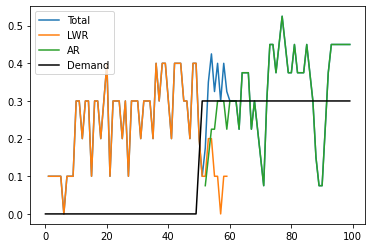

In [37]:
energy = tm.get_monthly_electricity(out_file)
lwr_energy = get_lwr_energy(out_file, 'AdvancedReactor')
AR_energy = get_prototype_energy(out_file, 'AdvancedReactor')
plt.plot((energy['Year']-1965)*12, energy['Energy'], label='Total')
plt.plot(lwr_energy['Month'], lwr_energy['Energy'], label='LWR')
plt.plot(AR_energy['Month'], AR_energy['Energy'], label='AR')
t = np.linspace(0, 99, 100)
plt.plot(t, np.heaviside(t-50, 0.5)*.3, 'k', label='Demand')
plt.legend()

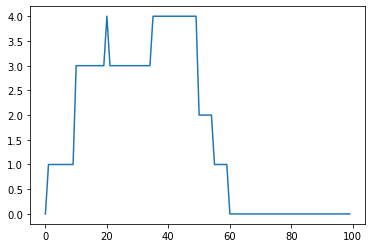

In [14]:
non_lwr = ['source', 'sink', 'AdvancedReactor', 
               'LWRDeployment', 'sink_source_facilities',
               'SingleRegion', 'source_inst']
reactors = tm.rx_commission_decommission(out_file, non_lwr)
plt.plot(reactors['Time'], reactors['lwr_total'])

45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    1.0
53    1.0
54    1.0
Name: advrx_enter, dtype: float64

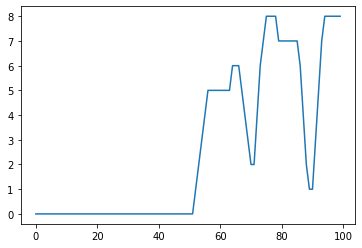

In [25]:
advrx_numbers = tm.prototype_totals(out_file, non_lwr, ['AdvancedReactor'])
plt.plot(advrx_numbers['Time'], advrx_numbers['advrx_total'])
advrx_numbers['advrx_enter'][45:55] #The first AdvancedReactor is commissioned at time step 52.

## Comparing d3ploy to ManagerInst

In [24]:
manager_inst_file = "../../transition-scenarios/input/haleu/outputs/xe100_nogrowth.sqlite"
d3ploy_file = "xe100_d3ploy.sqlite"

In [27]:
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100', ]
manager_inst_reactors = tm.prototype_totals(manager_inst_file, non_lwr, ['Xe-100'])
d3ploy_reactors = tm.prototype_totals(d3ploy_file, non_lwr, ['Xe-100'])

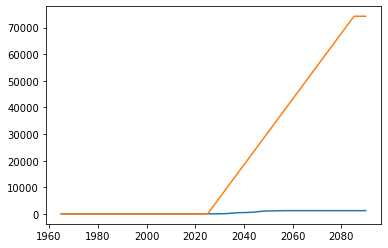

In [29]:
plt.plot(manager_inst_reactors['Year'], manager_inst_reactors['Xe-100_total'])
plt.plot(d3ploy_reactors['Year'], d3ploy_reactors['Xe-100_total'])

In [32]:
manager_inst_energy = tm.get_annual_electricity(manager_inst_file)
d3ploy_energy = tm.get_annual_electricity(d3ploy_file)

Text(0, 0.5, 'Energy (GWe-yr)')

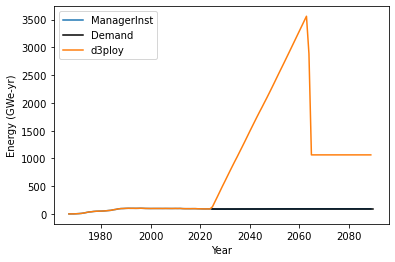

In [34]:
plt.plot(manager_inst_energy['Year'], manager_inst_energy['Energy'], label='ManagerInst')
plt.plot(np.linspace(2025, 2090, 50), np.repeat(91.818, 50),'k', label='Demand')
plt.plot(d3ploy_energy['Year'], d3ploy_energy['Energy'], label='d3ploy')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')